In [13]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('images'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

images\00000000.jpg
images\00000000_(2).jpg
images\00000000_(3).jpg
images\00000000_(4).jpg
images\00000000_(5).jpg
images\00000000_(6).jpg
images\00000000_(7).jpg
images\00000001.jpg
images\00000001_(2).jpg
images\00000001_(3).jpg
images\00000001_(4).jpg
images\00000001_(5).jpg
images\00000001_(6).jpg
images\00000001_(7).jpg
images\00000002.jpg
images\00000002_(2).jpg
images\00000002_(3).jpg
images\00000002_(4).jpg
images\00000002_(5).jpg
images\00000002_(6).jpg
images\00000003.jpg
images\00000003_(2).jpg
images\00000003_(3).jpg
images\00000003_(4).jpg
images\00000003_(5).jpg
images\00000003_(6).jpg
images\00000003_(7).jpg
images\00000004.jpg
images\00000004_(2).jpg
images\00000004_(3).jpg
images\00000004_(4).jpg
images\00000004_(5).jpg
images\00000004_(6).jpg
images\00000004_(7).jpg
images\00000005.jpg
images\00000005_(2).jpg
images\00000005_(3).jpg
images\00000005_(4).jpg
images\00000005_(5).jpg
images\00000005_(6).jpg
images\00000005_(7).jpg
images\00000006.jpg
images\00000006_(2).

In [14]:
!nvidia-smi

Thu May  4 15:18:25 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.79                 Driver Version: 531.79       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1660 T...  WDDM | 00000000:01:00.0 Off |                  N/A |
| N/A   49C    P8                5W /  N/A|      0MiB /  6144MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# ***Importing libraries and training data***

In [15]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [16]:
path = "images"
names = os.listdir(path)
#Number of images to use (n)
n = None
tr_urls = np.copy(names[:n])
print('''
All images {}
Train images {}
'''.format(len(names),len(tr_urls)))


All images 4319
Train images 4319



In [17]:
#The resolution of the training images will be 256x256 with 3 channels
def open_image(filename):
    img = tf.cast(tf.image.decode_jpeg(tf.io.read_file(path + "/" + filename),channels=3),tf.float32)
    img = tf.image.resize(img,[256,256],method='area')
    img = img/127.5-1
    return img

In [18]:
train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
train_dataset = train_dataset.map(open_image,num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


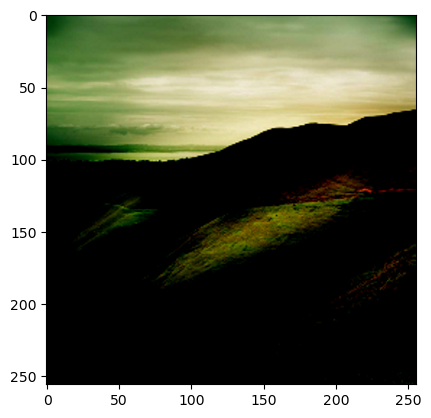

In [19]:
for img in train_dataset.take(1):
    plt.imshow(img[0],interpolation="spline16")
    plt.show()

In [20]:
!pip install tensorflow-addons

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     -------------------------------------- 736.6/736.6 kB 7.7 MB/s eta 0:00:00


In [21]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model,Sequential
#Even though I import Instance Normalization, I don't recommend using it for this architecture
from tensorflow_addons.layers import InstanceNormalization

C:\Users\vamsi\AppData\Roaming\Python\Python310\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# ***Defining the generator***

In [22]:
def Upsample(filters,size=3,use_drop=False):
    init = tf.random_normal_initializer(0,0.02)
    layer = Sequential()
    layer.add(Conv2DTranspose(filters,
                              size,
                              kernel_initializer=init,
                              padding='same',
                              strides=2,
                              use_bias=False,))
    layer.add(BatchNormalization())
    if use_drop:
        layer.add(Dropout(0.5))
    layer.add(ReLU())
    return layer

In [23]:
def Generator():
    input_noise = Input(shape=[512,])
    layers = [
        Dense(512*4*4),
        Reshape((4,4,512)),
        Upsample(512,use_drop=True),
        Upsample(512,use_drop=True),
        Upsample(512),
        Upsample(256),
        Upsample(128),
        Upsample(64),
    ]
    last = Conv2DTranspose(3,4,padding='same',activation='tanh')
    x = input_noise
    for layer in layers:
        x = layer(x)
    last = last(x)
    return Model(input_noise,last)

# ***Defining the discriminator***

In [24]:
def Downsample(filters,size=4,strides=2,use_instance=True):
    init = tf.random_normal_initializer(0,0.02)
    layer = Sequential()
    layer.add(Conv2D(filters,
                     size,
                     strides=strides,
                     kernel_initializer=init,
                     padding='same',
                     use_bias=not use_instance))
    if use_instance:
        layer.add(BatchNormalization())
    layer.add(LeakyReLU(0.2))
    return layer

In [25]:
#The type of discriminator used is PatchGAN type
def Discriminator():
    input_image = Input(shape=[256,256,3])
    layers = [
        Downsample(64,use_instance=False),
        Downsample(128),
        Downsample(256),
        Downsample(512),
    ]
    last = Conv2D(1,4,padding='same')
    x = input_image
    for layer in layers:
        x = layer(x)
    last = last(x)
    return Model(input_image,last)

In [26]:
generator = Generator()
discriminator = Discriminator()

In [27]:
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512)]             0         
                                                                 
 dense (Dense)               (None, 8192)              4202496   
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 sequential (Sequential)     (None, 8, 8, 512)         2361344   
                                                                 
 sequential_1 (Sequential)   (None, 16, 16, 512)       2361344   
                                                                 
 sequential_2 (Sequential)   (None, 32, 32, 512)       2361344   
                                                                 
 sequential_3 (Sequential)   (None, 64, 64, 256)       118067

In [28]:
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_6 (Sequential)   (None, 128, 128, 64)      3136      
                                                                 
 sequential_7 (Sequential)   (None, 64, 64, 128)       131584    
                                                                 
 sequential_8 (Sequential)   (None, 32, 32, 256)       525312    
                                                                 
 sequential_9 (Sequential)   (None, 16, 16, 512)       2099200   
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 1)         8193      
                                                                 
Total params: 2,767,425
Trainable params: 2,765,633
Non-tra

In [29]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4,beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4,beta_1=0.5)

In [30]:
#To save and restore data
ckpt_path = "/kaggle/output//kaggle/working/checkpoints/"
ckpt_prefix = os.path.join(ckpt_path,"ckpt")
ckpt = tf.train.Checkpoint(
    generator = generator,
    discriminator = discriminator,
    generator_optimizer = generator_optimizer,
    discriminator_optimizer = discriminator_optimizer
)

In [31]:
ckpt.save(ckpt_prefix)

'/kaggle/output//kaggle/working/checkpoints/ckpt-1'

In [32]:
!ls /kaggle/output/kaggle/working/checkpoints/

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [33]:
ckpt.restore(tf.train.latest_checkpoint(ckpt_path))

In [34]:
def generate_images():
    noise = tf.random.normal([4,512])
    preds = generator(noise,training=True)*0.5+0.5
    plt.figure(figsize=(7,7))
    for i,img in enumerate(preds):
        plt.subplot(2,2,i+1)
        plt.axis('off')
        plt.imshow(img,interpolation="spline16")
    plt.show()

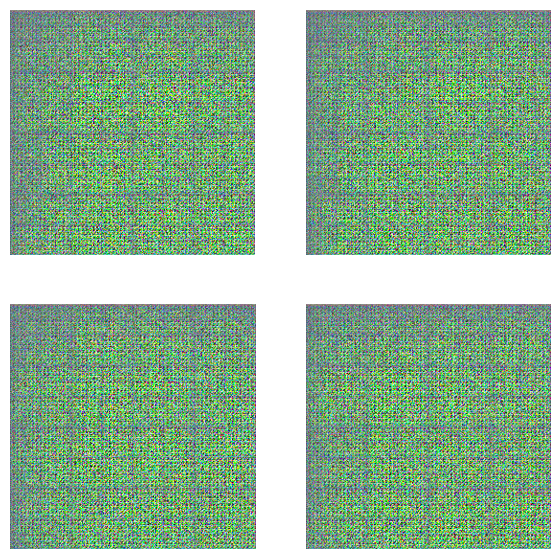

In [35]:
generate_images()

# ***Training***

In [36]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [37]:
def generator_loss(fake_out):
    return loss_object(tf.ones_like(fake_out),fake_out)

def discriminator_loss(real_out,fake_out):
    real_loss = loss_object(tf.ones_like(real_out),real_out)
    gen_loss = loss_object(tf.zeros_like(fake_out),fake_out)
    return real_loss + gen_loss

In [38]:
@tf.function
def train_step(img):
    noise = tf.random.normal([tf.shape(img)[0],512])
    with tf.GradientTape() as gen_tape,tf.GradientTape() as disc_tape:
        preds = generator(noise,training=True)
        
        real_out = discriminator(img,training=True)
        fake_out = discriminator(preds,training=True)
        
        gen_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out,fake_out)
        
        gen_grads = gen_tape.gradient(gen_loss,generator.trainable_variables)
        disc_grads = disc_tape.gradient(disc_loss,discriminator.trainable_variables)
        
        generator_optimizer.apply_gradients(zip(gen_grads,generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(disc_grads,discriminator.trainable_variables))

In [39]:
def train(epochs=1):
    for epoch in range(epochs):
        clear_output()
        generate_images()
        i = 0
        print("Epoch {}".format(epoch+1))
        for img in train_dataset:
            train_step(img)
            print(".",end="")
            i+=1
            if i%100==0:
                print()

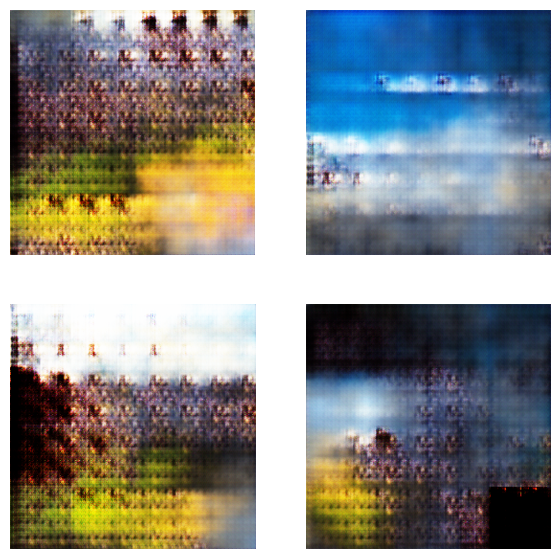

Epoch 25
....................................................................................................
...................................

In [40]:
train(25)

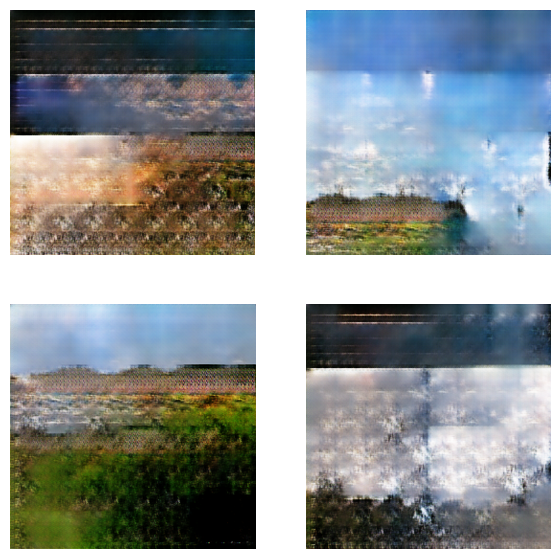

Epoch 25
....................................................................................................
...................................

In [41]:
train(25)